# Audio Recognition using Tensorflow

This approach uses CNN to build a classifier for audio inputs

## Import necessary modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from utils import *
import datetime

%matplotlib inline
np.random.seed(1)

## Import the dataset

In [2]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_data()

## Explore the dataset

In [3]:
X_train = X_train_orig
X_test = X_test_orig
Y_train = convert_to_one_hot(Y_train_orig, classes)
Y_test = convert_to_one_hot(Y_test_orig, classes)
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 58248
number of test examples = 6473
X_train shape: (58248, 16000, 1, 1)
Y_train shape: (58248, 30)
X_test shape: (6473, 16000, 1, 1)
Y_test shape: (6473, 30)


## Create input placeholders

Tensorflow placeholders for X and Y. These will be dynamically set during batch G.D at runtime

In [4]:
def create_placeholders(n_l, n_y):
    """
    Creates the placeholders for the tensorflow session.

    Arguments:
    n_l -- scalar, length of the audio vector
    n_y -- scalar, number of classes

    Returns:
    X -- placeholder for the data input, of shape [None, n_l] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """
    X = tf.placeholder(tf.float32, shape=(None, n_l, 1, 1))
    Y = tf.placeholder(tf.float32, shape=(None, n_y))

    return X, Y

In [5]:
# X, Y = create_placeholders(500, 20)
# print ("X = " + str(X))
# print ("Y = " + str(Y))

## Initialize Parameters

With tensorflow we only need to initialize parameters for Conv layers. Fully connected layers' paramaters are completed handled by the framework.

In [6]:
def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
    W1 : [4, 1, 1, 8]
    W2 : [2, 1, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """

    tf.set_random_seed(1)

    W1 = tf.get_variable("W1", [4,1,1,8], initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [2,1,8,16], initializer=tf.contrib.layers.xavier_initializer(seed = 0))

    parameters = {"W1": W1, "W2": W2}

    return parameters

In [7]:
# tf.reset_default_graph()
# with tf.Session() as sess_test:
#     parameters = initialize_parameters()
#     init = tf.global_variables_initializer()
#     sess_test.run(init)
#     print("W1 = " + str(parameters["W1"].eval()[0,0,0]))
#     print("W2 = " + str(parameters["W2"].eval()[0,0,0]))

## Forward Propagation

CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

Following are the parameters for all the layers:
    - Conv2D: stride 1, padding is "SAME"
    - ReLU
    - Max pool: 8 by 1 filter size and an 8 by 1 stride, padding is "SAME"
    - Conv2D: stride 1, padding is "SAME"
    - ReLU
    - Max pool: 4 by 1 filter size and a 4 by 1 stride, padding is "SAME"
    - Flatten the previous output.
    - FULLYCONNECTED (FC) layer: outputs 30 classes one for each audio utterance

In [8]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing parameters "W1", "W2"
    the shapes are given in initialize_parameters
    Returns:
    Z3 -- the output of the last LINEAR unit
    """

    # Retrieve the parameters from the dictionary "parameters"
    W1 = parameters['W1']
    W2 = parameters['W2']

    Z1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = 'SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize = [1,8,1,1], strides = [1,8,1,1], padding = 'SAME')
    Z2 = tf.nn.conv2d(P1, W2, strides = [1,1,1,1], padding = 'SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize = [1,4,1,1], strides = [1,4,1,1], padding = 'SAME')
    P2 = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(P2, 30, activation_fn=None)

    return Z3

In [9]:
# tf.reset_default_graph()
# with tf.Session() as sess:
#     np.random.seed(1)
#     X, Y = create_placeholders(64, 5)
#     parameters = initialize_parameters()
#     Z3 = forward_propagation(X, parameters)
#     init = tf.global_variables_initializer()
#     sess.run(init)
#     a = sess.run(Z3, {X: np.random.randn(2,64,1,1), Y: np.random.randn(2,5)})
#     print("Z3 = " + str(a))

## Compute Cost

Using the last layer Z3, compute softmax and J

In [10]:
def compute_cost(Z3, Y):
    """
    Computes the cost

    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (30, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3

    Returns:
    cost - Tensor of the cost function
    """

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))

    return cost

In [11]:
# tf.reset_default_graph()
# with tf.Session() as sess:
#     np.random.seed(1)
#     X, Y = create_placeholders(64, 30)
#     parameters = initialize_parameters()
#     Z3 = forward_propagation(X, parameters)
#     cost = compute_cost(Z3, Y)
#     init = tf.global_variables_initializer()
#     sess.run(init)
#     a = sess.run(cost, {X: np.random.randn(4,64,1,1), Y: np.random.randn(4,30)})
#     print("cost = " + str(a))

## Model

Connects all the functions and sets up training with mini batches

In [12]:
tf.reset_default_graph() # to be able to rerun the model without overwriting tf variables

# Start an interactive session
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))

In [13]:
def model(sess, X_train, Y_train, X_test, Y_test, learning_rate = 0.009, num_epochs = 100, 
          minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

    Arguments:
    X_train -- training set, of shape (None, 16000, 1, 1)
    Y_train -- test set, of shape (None, n_y = 30)
    X_test -- training set, of shape (None, 16000, 1, 1)
    Y_test -- test set, of shape (None, n_y = 30)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs

    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    tf.set_random_seed(1) # to keep results consistent (tensorflow seed)
    seed = 3 # to keep results consistent (numpy seed)
    (m, n_l, _, __) = X_train.shape
    n_y = Y_train.shape[1]
    costs = [] # To keep track of the cost

    X, Y = create_placeholders(n_l, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    # print("Cost before iteration %s" % (cost,))

    # Backpropagation: Using AdamOptimizer to minimize the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

    # Run the initialization
    sess.run(tf.global_variables_initializer())

    # Do the training loop
    for epoch in range(num_epochs):
        minibatch_cost = 0.
        # print("> epoch = %s, m = %s, mini size = %s, mini cost = %s" % (epoch, m, minibatch_size, minibatch_cost))
        num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
        seed = seed + 1
        minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch
            # print(">> mini X.shape = %s, mini Y.shape = %s" % (minibatch_X.shape, minibatch_Y.shape))
            # IMPORTANT: The line that runs the graph on a minibatch.
            # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
            _ , temp_cost = sess.run([optimizer, cost], feed_dict = {X: minibatch_X, Y: minibatch_Y})
            # print(">> Temp cost = %s" % temp_cost)
            minibatch_cost += temp_cost / num_minibatches

        # Print the cost every epoch
        if print_cost == True and epoch % 5 == 0:
            print("%s: Cost after epoch %i: %f" % (datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'), epoch, minibatch_cost))
        if print_cost == True and epoch % 1 == 0:
            costs.append(minibatch_cost)


    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return Z3, X, Y, parameters

2017-12-30 03:37:53: Cost after epoch 0: 2.896276
2017-12-30 03:48:17: Cost after epoch 5: 1.989014
2017-12-30 03:58:30: Cost after epoch 10: 1.582006
2017-12-30 04:08:49: Cost after epoch 15: 1.385744
2017-12-30 04:19:07: Cost after epoch 20: 1.232127
2017-12-30 04:29:19: Cost after epoch 25: 1.111863
2017-12-30 04:39:34: Cost after epoch 30: 1.033235
2017-12-30 04:49:51: Cost after epoch 35: 0.970010
2017-12-30 05:00:07: Cost after epoch 40: 0.929157
2017-12-30 05:10:28: Cost after epoch 45: 0.875097
2017-12-30 05:20:43: Cost after epoch 50: 0.828555
2017-12-30 05:30:58: Cost after epoch 55: 0.813558
2017-12-30 05:41:20: Cost after epoch 60: 0.796425
2017-12-30 05:51:33: Cost after epoch 65: 0.781662
2017-12-30 06:01:55: Cost after epoch 70: 0.770729
2017-12-30 06:12:11: Cost after epoch 75: 0.729644
2017-12-30 06:22:30: Cost after epoch 80: 0.696113
2017-12-30 06:32:48: Cost after epoch 85: 0.687922
2017-12-30 06:43:04: Cost after epoch 90: 0.704297
2017-12-30 06:53:21: Cost after e

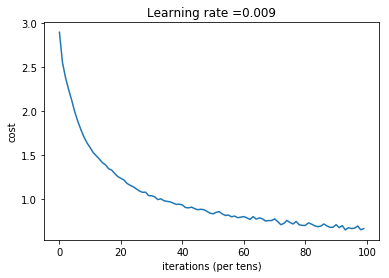

In [14]:
Z3, X, Y, parameters = model(sess, X_train, Y_train, X_test, Y_test)

## Save model to disk

In [27]:
# saver = tf.train.Saver()
# saver.save(sess, '../saved_models/cnn-tf-model')

meta_graph_def = tf.train.export_meta_graph(filename='../saved_models/my-cnn-tf-model.meta')
meta_graph_def

meta_info_def {
  stripped_op_list {
    op {
      name: "Add"
      input_arg {
        name: "x"
        type_attr: "T"
      }
      input_arg {
        name: "y"
        type_attr: "T"
      }
      output_arg {
        name: "z"
        type_attr: "T"
      }
      attr {
        name: "T"
        type: "type"
        allowed_values {
          list {
            type: DT_HALF
            type: DT_FLOAT
            type: DT_DOUBLE
            type: DT_UINT8
            type: DT_INT8
            type: DT_INT16
            type: DT_INT32
            type: DT_INT64
            type: DT_COMPLEX64
            type: DT_COMPLEX128
            type: DT_STRING
          }
        }
      }
    }
    op {
      name: "ApplyAdam"
      input_arg {
        name: "var"
        type_attr: "T"
        is_ref: true
      }
      input_arg {
        name: "m"
        type_attr: "T"
        is_ref: true
      }
      input_arg {
        name: "v"
        type_attr: "T"
        is_ref: true
      }

In [23]:
print("W1 = " + str(parameters["W1"].eval()[0,0,0]))

W1 = [ 0.77402604 -1.78282261  1.72925854 -2.64366388 -1.91047382  0.07037733
 -1.52699935  1.67225623]


In [26]:
print(tf.train.latest_checkpoint('../saved_models/'))

../saved_models/cnn-tf-model


In [30]:
def model_accuracy(X_train, Y_train, X_test, Y_test, Z3, X, Y):
    # Calculate the correct predictions
    predict_op = tf.argmax(Z3, 1)
    correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
#     train_accuracy = accuracy.eval({X: X_train, Y: Y_train}, session = sess)
    test_accuracy = accuracy.eval({X: X_test, Y: Y_test}, session = sess)

#     print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)

#     return train_accuracy, test_accuracy    
    return test_accuracy

In [31]:
sess.list_devices()

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]

In [32]:
# train_accuracy, test_accuracy = model_accuracy(X_train, Y_train, X_test, Y_test, Z3, X, Y)
test_accuracy = model_accuracy(X_train, Y_train, X_test, Y_test, Z3, X, Y)

Test Accuracy: 0.243473
